# Spotify Recommendation System
**Author: Daniel Hassler**

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Data Analysis
Look at -> 
* https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb
* https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/code

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'track_id', 'artists',
       'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre'],
      dtype='object')
(81344, 23)


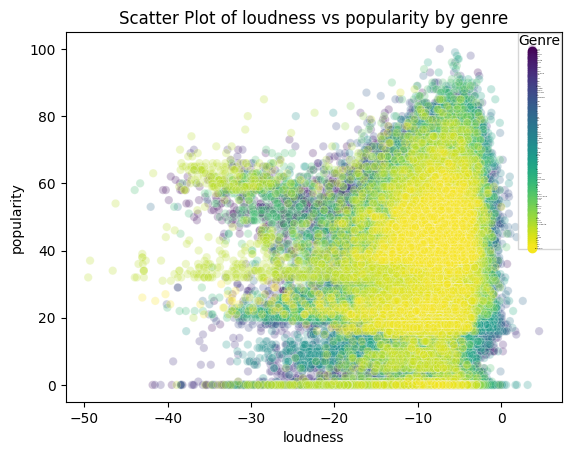

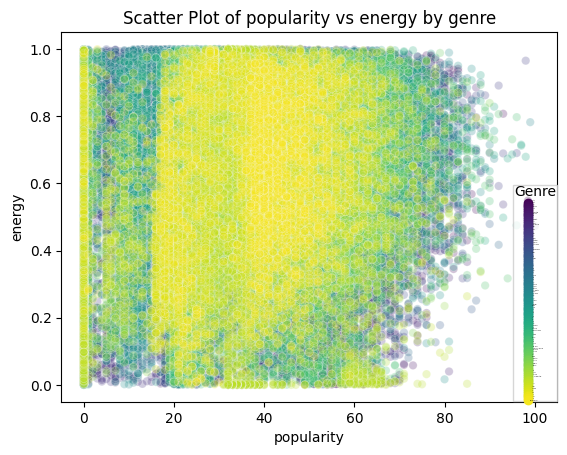

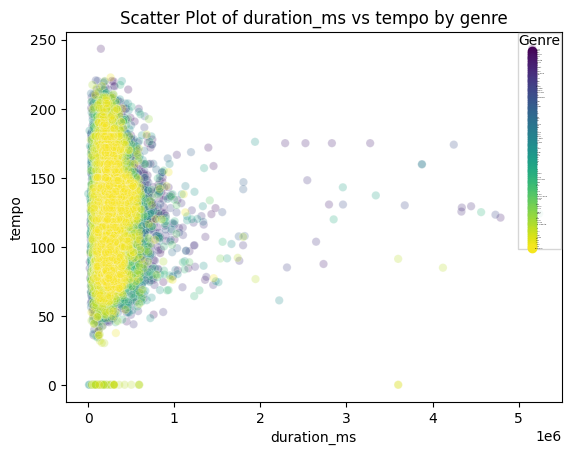

In [170]:
original_df = pd.read_csv("./dataset-dedup.csv")
print(original_df.columns)
# original_df = original_df.drop_duplicates(subset=["artists", "track_name"], keep="first").reset_index()
print(original_df.shape)
# original_df.to_csv("./dataset-dedup.csv")
features_x = ["loudness", "popularity", "duration_ms"]
features_y = ["popularity", "energy", "tempo"]

for i, (x,y) in enumerate(zip(features_x, features_y)):
    scatter = sns.scatterplot(x=x, y=y, hue='track_genre', data=original_df, palette="viridis", alpha=0.25)
    legend_labels = original_df['track_genre'].unique()# [:3]  # Show only the first 3 genres
    scatter.legend(title='Genre', labels=legend_labels, prop={'size': 1})
    plt.title(f"Scatter Plot of {x} vs {y} by genre")
    plt.show()

plt.show()

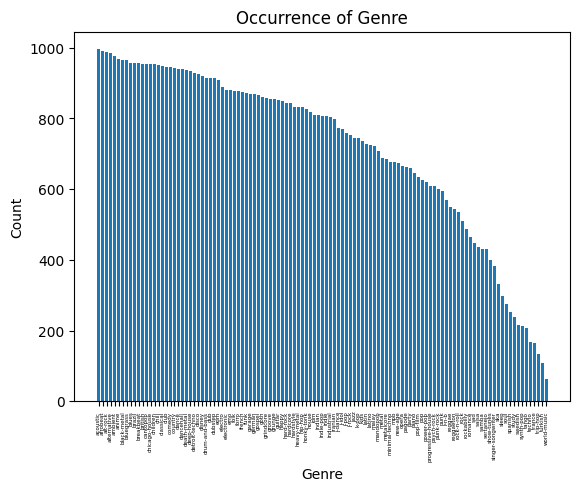

In [191]:
unique_vals = original_df['track_genre'].unique()
plt.bar(unique_vals, original_df['track_genre'].value_counts())
plt.title("Occurrence of Genre")
plt.ylabel("Count")
plt.xlabel("Genre")
_ = plt.xticks(rotation="vertical", fontsize=4)

## K-Means Clustering

### Hyperparameter Tuning for K-Means

In [171]:
inertia = []
# train_df is the numeric representation of original_df
train_df = original_df.drop(columns=['Unnamed: 0.1', 'index', 'Unnamed: 0', 'track_id',
       'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'])

for col in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[col]):
        train_df[col] = pd.factorize(original_df[col])[0]

scaler = StandardScaler()
# df_scaled is the scaled version of train_df
df_scaled = scaler.fit_transform(train_df)
pca_num_components = 2

# df_pca to reduce dimensionality
pca = PCA(n_components=pca_num_components).fit_transform(df_scaled)
df_pca = pd.DataFrame(pca,columns=['pca1','pca2'])

for k in range(1, 80, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(df_pca)
    inertia.append(kmeans.inertia_)

d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

### Plotting the Elbow Chart

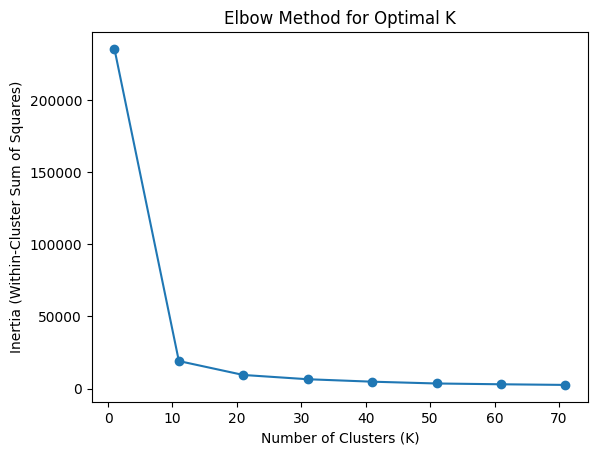

In [172]:
# Plot the elbow curve
plt.plot(range(1, 80, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()

### Choosing K-Means with "Elbow" Point

In [173]:
kmeans = KMeans(n_clusters=10, random_state=42)
original_df['clusters'] = kmeans.fit_predict(df_pca)

d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


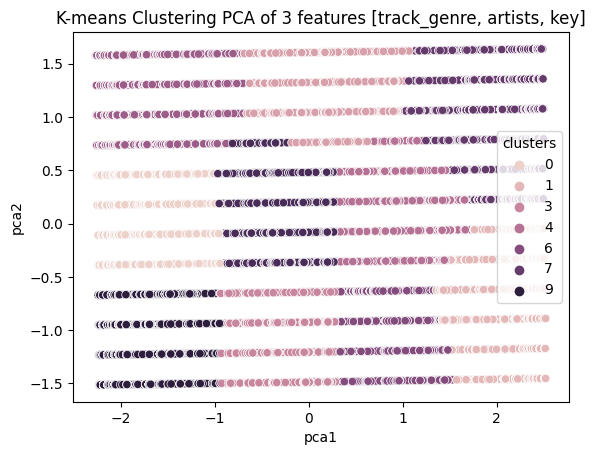

In [174]:
sns.scatterplot(x="pca1", y="pca2", hue=original_df['clusters'], data=df_pca)
plt.title('K-means Clustering PCA of 3 features [track_genre, artists, key]')
plt.show()

## Evaluation

In [175]:
original_df['Distance_to_Centroid'] = kmeans.transform(df_pca).min(axis=1)

In [176]:
def get_nearest_entry(idx, k=5):
    # print(original_df.iloc[idx])
    # print(train_df.iloc[idx])
    cluster = kmeans.predict(df_pca.iloc[idx].to_frame().T)[0]
    cluster_data = original_df[original_df["clusters"] == cluster]
    cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
    cluster_data = cluster_data.sort_values(by="closest_entries_to_idx")
    # print(cluster_data[["artists", "album_name", "track_name", "track_genre"]])

    cluster_data.drop(columns=["closest_entries_to_idx"])
    print(f"Top {k} Closest Examples to {cluster_data.loc[idx]['artists']}'s \"{cluster_data.loc[idx]['track_name']}\"")
    print(cluster_data[:k][["artists", "track_name", "track_genre"]])
    print("\n\n")

get_nearest_entry(35640) # rock song
get_nearest_entry(16587) # country song
get_nearest_entry(41220) # rap song

Top 5 Closest Examples to Daughtry's "September"
            artists               track_name     track_genre
35640      Daughtry                September          grunge
35381      Daughtry            It's Not Over          grunge
35839    Stone Sour                 Hesitate          grunge
55666    Mark Broom                Five/Four  minimal-techno
40063  TNT;POPR3B3L  I'm Raving - Radio Edit       hardstyle



Top 5 Closest Examples to Florida Georgia Line's "Stay"
                    artists  \
16587  Florida Georgia Line   
8395    Datsik;Virtual Riot   
8582            The Prodigy   
8819            The Prodigy   
8529            The Prodigy   

                                              track_name track_genre  
16587                                               Stay     country  
8395                                               Nasty   breakbeat  
8582                                               Girls   breakbeat  
8819                                  We Are The Ruffes

C:\Users\dwh71\AppData\Local\Temp\ipykernel_7112\101083667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppData\Local\Temp\ipykernel_7112\101083667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppData

d:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


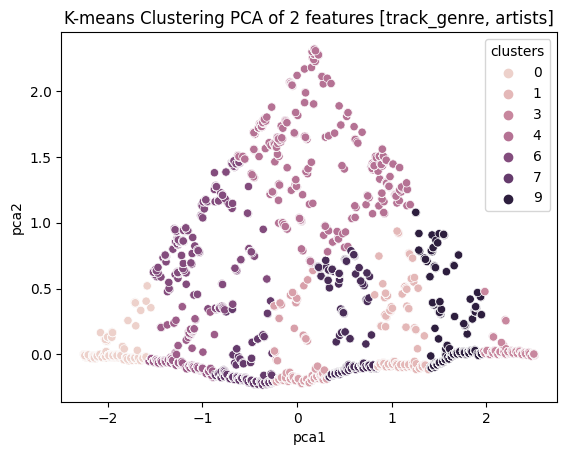

Top 5 Closest Examples to Daughtry's "September"
        artists            track_name track_genre
35439  Daughtry  Waiting for Superman      grunge
35678  Daughtry         Gone Too Soon      grunge
35802  Daughtry            I'll Fight      grunge
35640  Daughtry             September      grunge
35336  Daughtry                  Home      grunge



Top 5 Closest Examples to Florida Georgia Line's "Stay"
                    artists         track_name track_genre
16592  Florida Georgia Line  I Love My Country     country
16587  Florida Georgia Line               Stay     country
16938  Florida Georgia Line           H.O.L.Y.     country
16598  Florida Georgia Line           Sun Daze     country
16975  Florida Georgia Line               Life     country



Top 5 Closest Examples to Future;Lil Uzi Vert's "Tic Tac"
                   artists              track_name track_genre
41220  Future;Lil Uzi Vert                 Tic Tac     hip-hop
39123            Lionheart                  Cursed 

C:\Users\dwh71\AppData\Local\Temp\ipykernel_7112\101083667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppData\Local\Temp\ipykernel_7112\101083667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppData

In [177]:
original_df = pd.read_csv("./dataset-dedup.csv")
# train_df is the numeric representation of original_df
train_df = original_df.drop(columns=['Unnamed: 0.1', 'index', 'Unnamed: 0', 'track_id',
       'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'key', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'])

for col in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[col]):
        train_df[col] = pd.factorize(original_df[col])[0]

scaler = StandardScaler()
# df_scaled is the scaled version of train_df
df_scaled = scaler.fit_transform(train_df)
pca_num_components = 2

# df_pca to reduce dimensionality
pca = PCA(n_components=pca_num_components).fit_transform(df_scaled)
df_pca = pd.DataFrame(pca,columns=['pca1','pca2'])

kmeans = KMeans(n_clusters=10, random_state=42)
original_df['clusters'] = kmeans.fit_predict(df_pca)

sns.scatterplot(x="pca1", y="pca2", hue=original_df['clusters'], data=df_pca)
plt.title('K-means Clustering PCA of 2 features [track_genre, artists]')
plt.show()
original_df['Distance_to_Centroid'] = kmeans.transform(df_pca).min(axis=1)
get_nearest_entry(35640) # rock song
get_nearest_entry(16587) # country song
get_nearest_entry(41220) # rap song